In [1]:
font1 = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
font2 = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
font3 = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 14}

In [2]:
from torch.utils.data import Dataset
import numpy as np
import os
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
class AIP_dataset(Dataset):
    def __init__(self, feature_list, target_list):
        self.features = feature_list
        self.labels = target_list
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label
    def __len__(self):
        return len(self.labels)
def matrix_generator(data_file_path):
    fea_data = np.load(data_file_path, allow_pickle=True)
    matrices = fea_data[:, 1]
    max_row = max(matrix.shape[0] for matrix in matrices)
    padded_matrices = []
    for i, matrix in enumerate(matrices):
        if matrix.shape[0] <= max_row:
            zeros = np.zeros((max_row - matrix.shape[0], matrix.shape[1]))
            matrices[i] = np.vstack((matrix, zeros))
            padded_matrices.append(matrices[i])
    task_id = fea_data[:, 0]
    task_fea = np.array(padded_matrices, dtype=float)
    task_fea = task_fea.astype(np.float32)
    return task_fea, task_id

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gru1 = nn.GRU(input_size=45, hidden_size=128, num_layers=1, batch_first=True)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(in_features=128, out_features=32)
        # self.dropout2 = nn.Dropout(0.5)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=2)

    def forward(self, x):
        out, _ = self.gru1(x)
        out = self.relu1(out)
        out = self.fc1(out[:, -1, :])
        # out = self.dropout2(out)
        out = self.relu2(out)
        out = self.fc2(out)
        return out
pre_fea, pre_id = matrix_generator('train-all.npy')
tes_fea, tes_id = matrix_generator('test-all.npy')
pre_dataloader = DataLoader(AIP_dataset(pre_fea, pre_id), batch_size=64, shuffle=False)
tes_dataloader = DataLoader(AIP_dataset(tes_fea, tes_id), batch_size=64, shuffle=False)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.95)

/Users/ggcl7/opt/anaconda3/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/ggcl7/opt/anaconda3/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


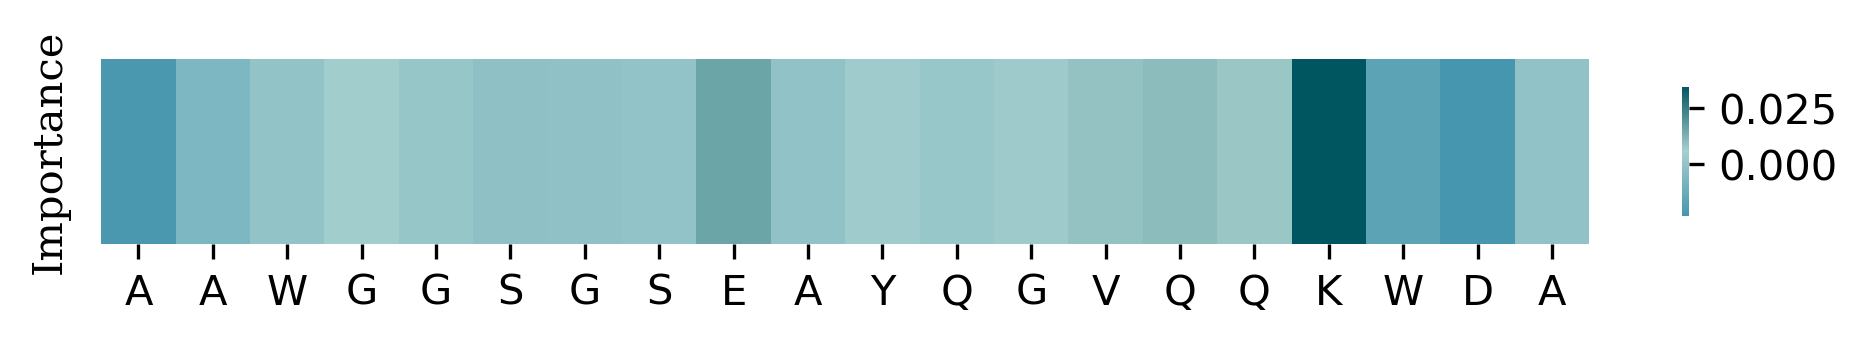

In [3]:
import torch
from captum.attr import DeepLift
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

model = Net()
model.load_state_dict(torch.load('GRU_final.pt'))
model.eval()

# 定义DeepLIFT解释器
explainer = DeepLift(model)

# 选择一个观察值进行解释
observation = pre_fea[3]
# 这只是一个例子，你可能需要选择一个具有代表性的观察值
observation = torch.from_numpy(observation).float().unsqueeze(0)

# 计算并展示特征重要性
attr = explainer.attribute(observation, target=1)
attr = attr.detach().numpy()

# Reshape attr to 2D (25, 45)
attr_2d = attr[0]
attr_sum = np.sum(attr_2d, axis=1)
xticklabels = np.arange(1, attr_sum.shape[0] + 1)
# Convert the sequence into a list of characters
sequence = list("AAWGGSGSEAYQGVQQKWDA")


sequence = sequence[:len(sequence)]

# Ensure the length of the sequence matches the length of attr_sum
assert len(sequence) == len(attr_sum[:len(sequence)]), "Length of sequence doesn't match the length of attr_sum"

plt.figure(figsize=(8, 0.8), dpi=300)
colors = ["#4696af", "#a6cfce", "#005660"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
sns.heatmap(attr_sum[:len(sequence)].reshape(1, -1), cmap=cmap, cbar_kws={'shrink': 0.7}, xticklabels=sequence)
plt.ylabel('Importance', font1)

plt.yticks([])

# Set the xticks to display the sequence
plt.xticks(np.arange(len(sequence)) + 0.5, sequence, rotation=0)  # +0.5 to center the tick

plt.show()
